In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np


In [15]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [16]:
df = pd.read_csv("file_train_senza_outliers.csv")

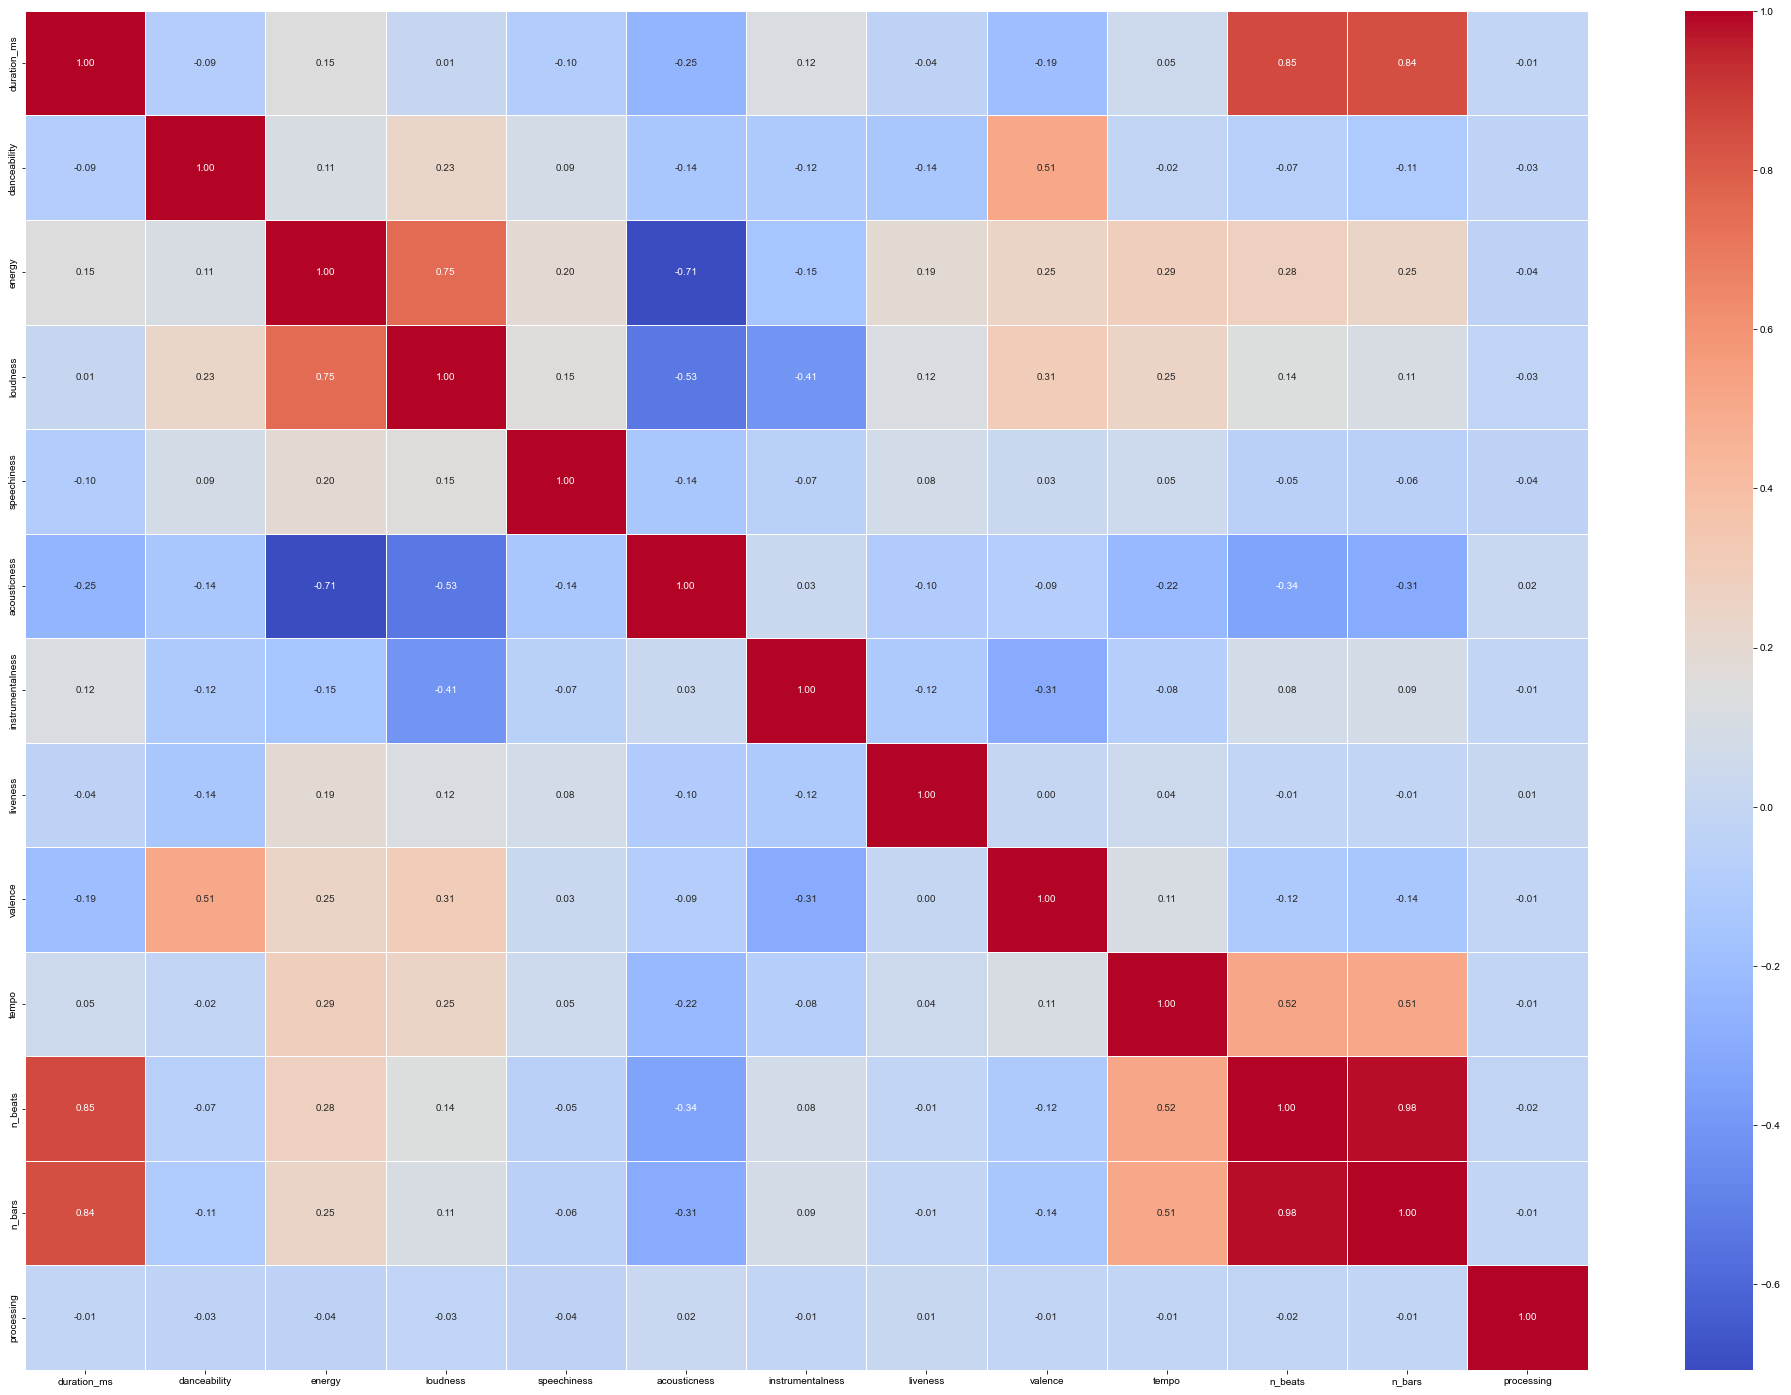

In [4]:
selected_columns = df[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing']]

plt.figure(figsize = (35, 25))
sns.heatmap(selected_columns.corr(),cmap='coolwarm', annot=True, fmt=".2f", linewidth='.8') 
sns.set(font_scale=1)

In [5]:
X = df.select_dtypes(include=float).values
#y = np.array(df['target'])
#y_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
#y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)

In [6]:
# z-score, fit and then transform
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)

In [7]:
# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [8]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=2, n_init=10)

In [9]:
kmeans.labels_

array([0, 1, 0, ..., 0, 0, 0])

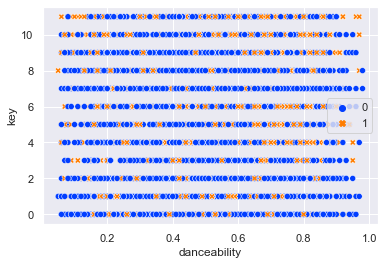

In [10]:
sns.scatterplot(data=df, 
                x="danceability",
                y="key",
                hue=kmeans.labels_,
                style=kmeans.labels_,
                palette="bright")
plt.show()

## DBScan

In [11]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

In [12]:
k=3
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

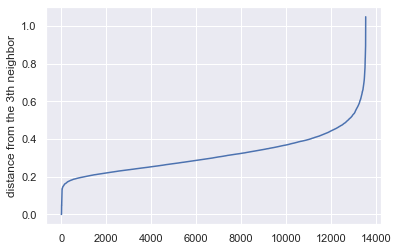

In [13]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
         
plt.show()

In [14]:
dbscan = DBSCAN(eps=0.50, min_samples=4, metric='precomputed')
dbscan.fit(dist)

DBSCAN(metric='precomputed', min_samples=4)

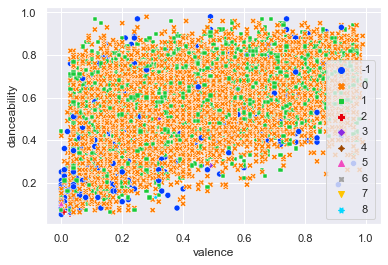

In [15]:
sns.scatterplot(data=df, 
                x="valence", 
                y="danceability", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()

## C-Means (fuzzy means)

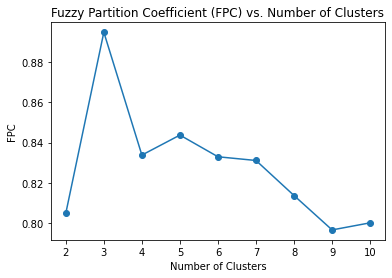

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Extract the data from the two columns of interest
data = df.select_dtypes(include=float).values

# min-max, fit and trasform directly
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# Define a range of cluster numbers to try
num_clusters = range(2, 11)  # Try clusters from 2 to 10

# Lists to store FPC values for each cluster number
fpc_values = []

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Perform Fuzzy C-Means clustering for each cluster number
for c in num_clusters:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data_scaled.T, c, m, error=tolerance, maxiter=max_iters, init=None, seed=94
    )
    fpc_values.append(fpc)

# Plot the FPC values against the number of clusters
plt.plot(num_clusters, fpc_values, marker='o')
plt.title('Fuzzy Partition Coefficient (FPC) vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('FPC')
plt.show()




Number of clusters: 2, Silhouette Score: 0.2518658333117589
Number of clusters: 3, Silhouette Score: 0.2021936754823263
Number of clusters: 4, Silhouette Score: 0.17400407791452827
Number of clusters: 5, Silhouette Score: 0.18128184394097202
Number of clusters: 6, Silhouette Score: 0.17783104261730484
Number of clusters: 7, Silhouette Score: 0.18756522511547016
Number of clusters: 8, Silhouette Score: 0.177246098433463
Number of clusters: 9, Silhouette Score: 0.16813337977860524


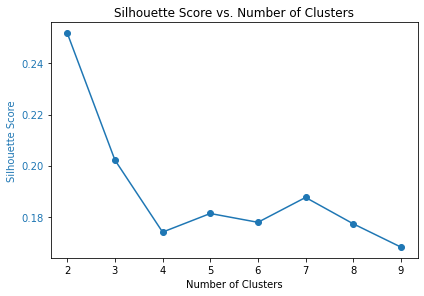

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Import davies_bouldin_score
import skfuzzy as fuzz

# Set a range of cluster numbers to try
cluster_range = range(2, 10)

silhouette_scores = []
davies_bouldin_scores = []

for num_clusters in cluster_range:
    # Perform Fuzzy C-Means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_scaled.T, num_clusters, 1.1, error=1e-3, maxiter=100, seed=94)
    
    # Get cluster assignments for each data point
    cluster_membership = np.argmax(u, axis=0)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(data_scaled, cluster_membership)
    silhouette_scores.append(silhouette_avg)
    

    print(f"Number of clusters: {num_clusters}, Silhouette Score: {silhouette_avg}")

# Plotting the results
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(cluster_range, silhouette_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()


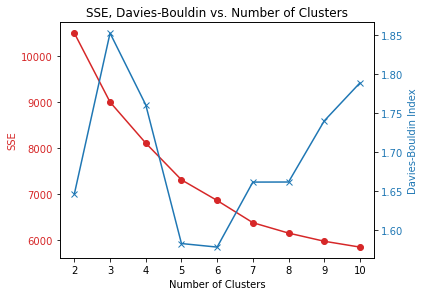

In [21]:
from sklearn.metrics import davies_bouldin_score

# Specify a range of cluster numbers to try
cluster_range = range(2, 11)  # Try clusters from 2 to 10

# Lists to store SSE, Davies-Bouldin, and FPC values for each cluster number
sse_values = []
db_values = []

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Perform Fuzzy C-Means clustering for each cluster number
for c in cluster_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data_scaled.T, c, m, error=tolerance, maxiter=max_iters, init=None, seed=94
    )
    
    # Calculate SSE
    sse = np.sum((np.min(d, axis=0))**2)
    sse_values.append(sse)
    
    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(data_scaled, np.argmax(u, axis=0))
    db_values.append(db_index)
    


# Plot SSE, Davies-Bouldin, and FPC values against the number of clusters
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('SSE', color=color)
ax1.plot(cluster_range, sse_values, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Davies-Bouldin Index', color=color)  
ax2.plot(cluster_range, db_values, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  
plt.title('SSE, Davies-Bouldin vs. Number of Clusters')
plt.show()


Fuzzy Partition Coefficient (FPC): 0.9641980945280006


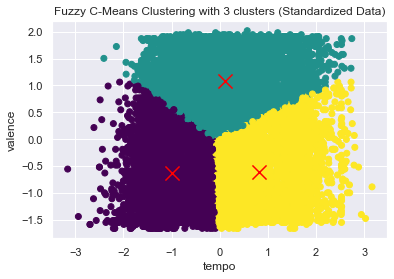

Davies–Bouldin Index: 3.776863602942678


In [19]:
#!pip install  scikit-fuzzy

import skfuzzy as fuzz

# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
dat = df[["tempo", "valence"]].values

# min-max, fit and trasform directly
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(dat)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_scale.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)


# Visualize the data and cluster centers
plt.scatter(data_scale[:, 0], data_scale[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Standardized Data)')
plt.xlabel("tempo")
plt.ylabel("valence")
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()




from sklearn.metrics import pairwise_distances
import numpy as np

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9702297535097792


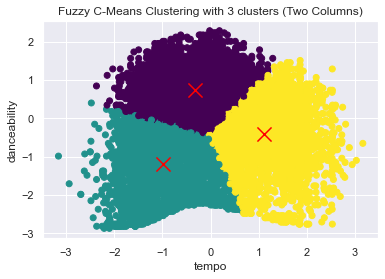

Davies–Bouldin Index: 4.201152721995304


In [20]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["tempo", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("tempo")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9675128253974198


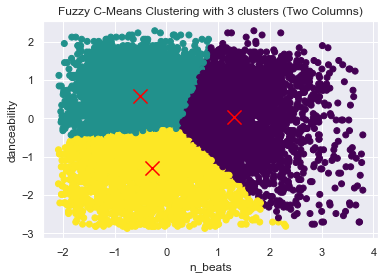

Davies–Bouldin Index: 4.064059956988807


In [21]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["n_beats", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("n_beats")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9688605132815017


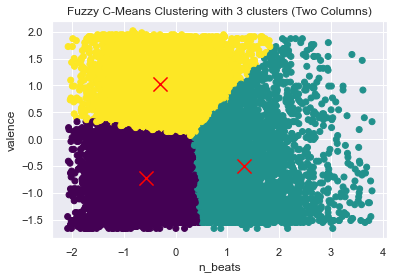

Davies–Bouldin Index: 3.8987036105396093


In [22]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["n_beats", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("n_beats")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9682664960574009


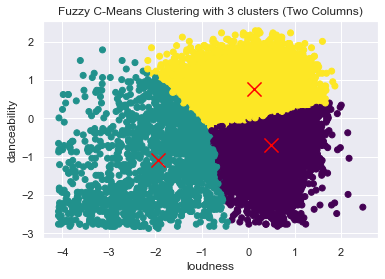

Davies–Bouldin Index: 4.870324347120518


In [23]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["loudness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("loudness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9732161179561257


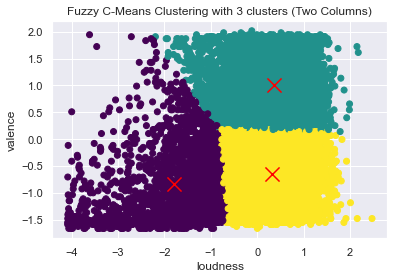

Davies–Bouldin Index: 4.472243332267744


In [24]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["loudness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("loudness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9728924479461967


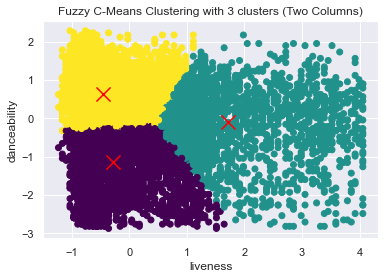

Davies–Bouldin Index: 4.588411746255532


In [25]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["liveness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("liveness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9737919046192592


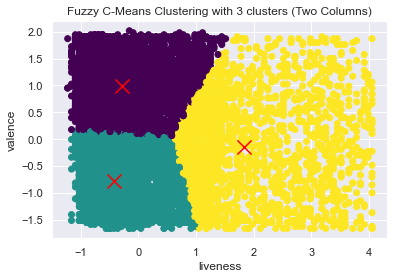

Davies–Bouldin Index: 4.728219934449185


In [26]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["liveness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("liveness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9728545789578859


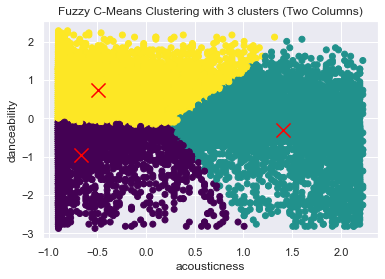

Davies–Bouldin Index: 4.043374571547795


In [27]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["acousticness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("acousticness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9769298187798842


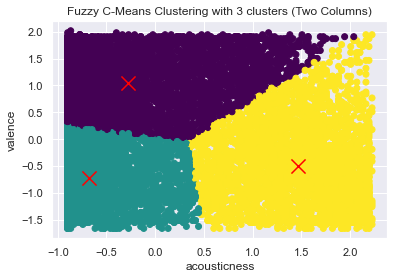

Davies–Bouldin Index: 4.352895269702613


In [28]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["acousticness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("acousticness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9776449976924986


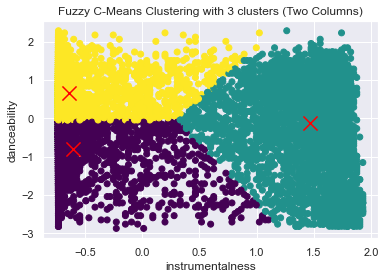

Davies–Bouldin Index: 3.7100544770406647


In [29]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["instrumentalness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("instrumentalness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9793669916238433


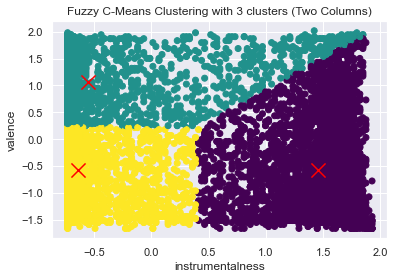

Davies–Bouldin Index: 4.101548380544608


In [30]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["instrumentalness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("instrumentalness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9636378977857946


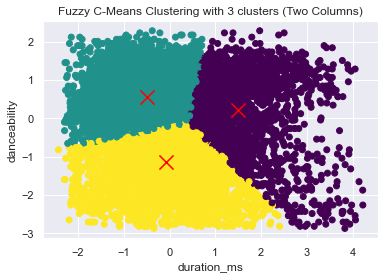

Davies–Bouldin Index: 3.9919341224001728


In [31]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["duration_ms", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("duration_ms")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9690998994631829


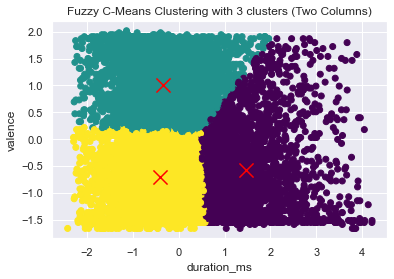

Davies–Bouldin Index: 3.8790534711138527


In [32]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["duration_ms", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("duration_ms")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9755478420194239


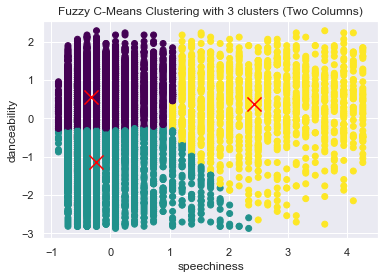

Davies–Bouldin Index: 6.233840558500631


In [33]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["speechiness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("speechiness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9800749207647693


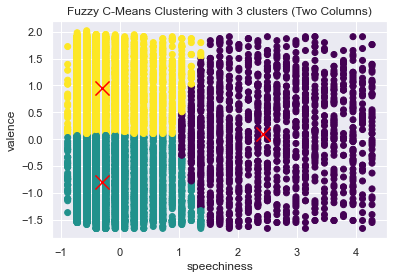

Davies–Bouldin Index: 6.225446537448637


In [34]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["speechiness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("speechiness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")
